In [91]:
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import torch
from torch import nn
from torchinfo import summary
from torch.optim import Adam
from torch.nn import CrossEntropyLoss
from tqdm import tqdm, trange

In [92]:
path = '/home/callum/AD_NC/'
image_size = 224
batch_size = 32

train_transform = transforms.Compose([
        transforms.Resize((image_size, image_size)),
        transforms.Grayscale(),
        transforms.ToTensor(),
    ])
    
test_transform = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.Grayscale(),
    transforms.ToTensor(),
])

train_dataset = ImageFolder(path + 'train', transform=train_transform)
train_dataloader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)

test_dataset = ImageFolder(path + 'test', transform=test_transform)
test_dataloader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=True)

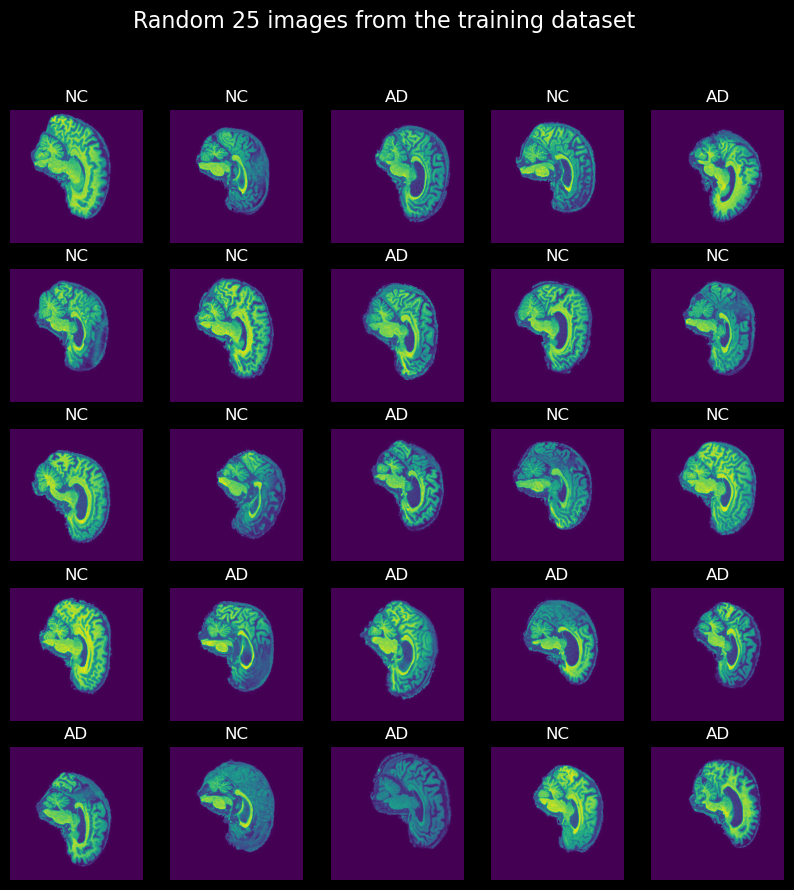

In [93]:
import matplotlib.pyplot as plt
import random

num_rows = 5
num_cols = num_rows

# Create a figure with subplots
fig, axs = plt.subplots(num_rows, num_cols, figsize=(10, 10))

# Iterate over the subplots and display random images from the training dataset
for i in range(num_rows):
    for j in range(num_cols):
        # Choose a random index from the training dataset
        image_index = random.randrange(len(train_dataset))

        # Display the image in the subplot
        axs[i, j].imshow(train_dataset[image_index][0].permute((1, 2, 0)))

        # Set the title of the subplot as the corresponding class name
        axs[i, j].set_title(train_dataset.classes[train_dataset[image_index][1]], color="white")

        # Disable the axis for better visualization
        axs[i, j].axis(False)

# Set the super title of the figure
fig.suptitle(f"Random {num_rows * num_cols} images from the training dataset", fontsize=16, color="white")

# Set the background color of the figure as black
fig.set_facecolor(color='black')

# Display the plot
plt.show()

In [94]:
patch_size = 16
channels = 1
embedding_dims = channels * patch_size**2
patches = (image_size // patch_size)**2

assert image_size % patch_size == 0, print('Image size not divisible by patch size')

In [95]:
conv_layer = nn.Conv2d(in_channels = channels, out_channels = embedding_dims, kernel_size = patch_size, stride = patch_size)

torch.Size([1, 224, 224])


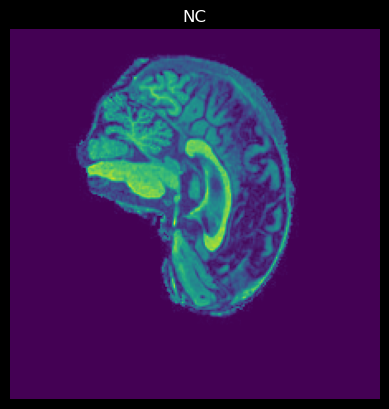

In [96]:
random_images, random_labels = next(iter(train_dataloader))
random_image = random_images[0]

# Create a new figure
fig = plt.figure(1)

print(random_image.size())

# Display the random image
plt.imshow(random_image.permute((1, 2, 0)))

# Disable the axis for better visualization
plt.axis(False)

# Set the title of the image
plt.title(train_dataset.classes[random_labels[0]], color="white")

# Set the background color of the figure as black
fig.set_facecolor(color="black")

In [97]:
# Pass the image through the convolution layer
image_through_conv = conv_layer(random_image.unsqueeze(0))
print(f'Shape of embeddings through the conv layer -> {list(image_through_conv.shape)} <- [batch_size, num_of_patch_rows,num_patch_cols embedding_dims]')

# Permute the dimensions of image_through_conv to match the expected shape
image_through_conv = image_through_conv.permute((0, 2, 3, 1))

# Create a flatten layer using nn.Flatten
flatten_layer = nn.Flatten(start_dim=1, end_dim=2)

# Pass the image_through_conv through the flatten layer
image_through_conv_and_flatten = flatten_layer(image_through_conv)

# Print the shape of the embedded image
print(f'Shape of embeddings through the flatten layer -> {list(image_through_conv_and_flatten.shape)} <- [batch_size, num_of_patches, embedding_dims]')

# Assign the embedded image to a variable
embedded_image = image_through_conv_and_flatten

Shape of embeddings through the conv layer -> [1, 256, 14, 14] <- [batch_size, num_of_patch_rows,num_patch_cols embedding_dims]
Shape of embeddings through the flatten layer -> [1, 196, 256] <- [batch_size, num_of_patches, embedding_dims]


In [98]:
class_token_embeddings = nn.Parameter(torch.rand((1, 1,embedding_dims), requires_grad  = True))
print(f'Shape of class_token_embeddings --> {list(class_token_embeddings.shape)} <-- [batch_size, 1, emdedding_dims]')

embedded_image_with_class_token_embeddings = torch.cat((class_token_embeddings, embedded_image), dim = 1)
print(f'\nShape of image embeddings with class_token_embeddings --> {list(embedded_image_with_class_token_embeddings.shape)} <-- [batch_size, num_of_patches+1, embeddiing_dims]')

position_embeddings = nn.Parameter(torch.rand((1, patches+1, embedding_dims ), requires_grad = True ))
print(f'\nShape of position_embeddings --> {list(position_embeddings.shape)} <-- [batch_size, num_patches+1, embeddings_dims]')

final_embeddings = embedded_image_with_class_token_embeddings + position_embeddings
print(f'\nShape of final_embeddings --> {list(final_embeddings.shape)} <-- [batch_size, num_patches+1, embeddings_dims]')

Shape of class_token_embeddings --> [1, 1, 256] <-- [batch_size, 1, emdedding_dims]

Shape of image embeddings with class_token_embeddings --> [1, 197, 256] <-- [batch_size, num_of_patches+1, embeddiing_dims]

Shape of position_embeddings --> [1, 197, 256] <-- [batch_size, num_patches+1, embeddings_dims]

Shape of final_embeddings --> [1, 197, 256] <-- [batch_size, num_patches+1, embeddings_dims]


In [99]:
class PatchEmbeddingLayer(nn.Module):
    def __init__(self, in_channels, patch_size, embedding_dim,):
        super().__init__()
        self.patch_size = patch_size
        self.embedding_dim = embedding_dim
        self.in_channels = in_channels
        self.conv_layer = nn.Conv2d(in_channels=in_channels, out_channels=embedding_dim, kernel_size=patch_size, stride=patch_size)
        self.flatten_layer = nn.Flatten(start_dim=1, end_dim=2)
        self.class_token_embeddings = nn.Parameter(torch.rand((batch_size, 1, embedding_dims), requires_grad=True))
        self.position_embeddings = nn.Parameter(torch.rand((1, patches + 1, embedding_dims), requires_grad=True))

    def forward(self, x):
        output = torch.cat((self.class_token_embeddings, self.flatten_layer(self.conv_layer(x).permute((0, 2, 3, 1)))), dim=1) + self.position_embeddings
        return output

In [100]:
patch_embedding_layer = PatchEmbeddingLayer(in_channels=channels, patch_size=patch_size, embedding_dim=channels * patch_size** 2)

patch_embeddings = patch_embedding_layer(random_images)
patch_embeddings.shape

torch.Size([32, 197, 256])

In [101]:
summary(model=patch_embedding_layer,
        input_size=(batch_size, channels, image_size, image_size), # (batch_size, input_channels, img_width, img_height)
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                       Input Shape          Output Shape         Param #              Trainable
PatchEmbeddingLayer (PatchEmbeddingLayer)     [32, 1, 224, 224]    [32, 197, 256]       58,624               True
├─Conv2d (conv_layer)                         [32, 1, 224, 224]    [32, 256, 14, 14]    65,792               True
├─Flatten (flatten_layer)                     [32, 14, 14, 256]    [32, 196, 256]       --                   --
Total params: 124,416
Trainable params: 124,416
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 412.65
Input size (MB): 6.42
Forward/backward pass size (MB): 12.85
Params size (MB): 0.26
Estimated Total Size (MB): 19.53

In [102]:
class MultiHeadSelfAttentionBlock(nn.Module):
  def __init__(self,
               embedding_dims = 256, # Hidden Size D in the ViT Paper Table 1
               num_heads = 12,  # Heads in the ViT Paper Table 1
               attn_dropout = 0.0 # Default to Zero as there is no dropout for the the MSA Block as per the ViT Paper
               ):
    super().__init__()

    self.embedding_dims = embedding_dims
    self.num_head = num_heads
    self.attn_dropout = attn_dropout

    self.layernorm = nn.LayerNorm(normalized_shape = embedding_dims)

    self.multiheadattention =  nn.MultiheadAttention(num_heads = num_heads,
                                                     embed_dim = embedding_dims,
                                                     dropout = attn_dropout,
                                                     batch_first = True,
                                                    )

  def forward(self, x):
    x = self.layernorm(x)
    output,_ = self.multiheadattention(query=x, key=x, value=x,need_weights=False)
    return output

In [103]:
multihead_self_attention_block = MultiHeadSelfAttentionBlock(embedding_dims = embedding_dims,
                                                             num_heads = 4
                                                             )
print(f'Shape of the input Patch Embeddings => {list(patch_embeddings.shape)} <= [batch_size, num_patches+1, embedding_dims ]')
print(f'Shape of the output from MSA Block => {list(multihead_self_attention_block(patch_embeddings).shape)} <= [batch_size, num_patches+1, embedding_dims ]')

Shape of the input Patch Embeddings => [32, 197, 256] <= [batch_size, num_patches+1, embedding_dims ]
Shape of the output from MSA Block => [32, 197, 256] <= [batch_size, num_patches+1, embedding_dims ]


In [104]:
summary(model=multihead_self_attention_block,
        input_size=(1, 197, 256), # (batch_size, num_patches, embedding_dimension)
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
MultiHeadSelfAttentionBlock (MultiHeadSelfAttentionBlock)    [1, 197, 256]        [1, 197, 256]        --                   True
├─LayerNorm (layernorm)                                      [1, 197, 256]        [1, 197, 256]        512                  True
├─MultiheadAttention (multiheadattention)                    --                   [1, 197, 256]        263,168              True
Total params: 263,680
Trainable params: 263,680
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 0.00
Input size (MB): 0.20
Forward/backward pass size (MB): 0.40
Params size (MB): 0.00
Estimated Total Size (MB): 0.61

In [105]:
class MachineLearningPerceptronBlock(nn.Module):
  def __init__(self, embedding_dims, mlp_size, mlp_dropout):
    super().__init__()
    self.embedding_dims = embedding_dims
    self.mlp_size = mlp_size
    self.dropout = mlp_dropout

    self.layernorm = nn.LayerNorm(normalized_shape = embedding_dims)
    self.mlp = nn.Sequential(
        nn.Linear(in_features = embedding_dims, out_features = mlp_size),
        nn.GELU(),
        nn.Dropout(p = mlp_dropout),
        nn.Linear(in_features = mlp_size, out_features = embedding_dims),
        nn.Dropout(p = mlp_dropout)
    )

  def forward(self, x):
    return self.mlp(self.layernorm(x))

In [108]:
mlp_block = MachineLearningPerceptronBlock(embedding_dims = embedding_dims,
                                           mlp_size = 3072,
                                           mlp_dropout = 0.1)

summary(model=mlp_block,
        input_size=(1, 197, 256), # (batch_size, num_patches, embedding_dimension)
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                                           Input Shape          Output Shape         Param #              Trainable
MachineLearningPerceptronBlock (MachineLearningPerceptronBlock)   [1, 197, 256]        [1, 197, 256]        --                   True
├─LayerNorm (layernorm)                                           [1, 197, 256]        [1, 197, 256]        512                  True
├─Sequential (mlp)                                                [1, 197, 256]        [1, 197, 256]        --                   True
│    └─Linear (0)                                                 [1, 197, 256]        [1, 197, 3072]       789,504              True
│    └─GELU (1)                                                   [1, 197, 3072]       [1, 197, 3072]       --                   --
│    └─Dropout (2)                                                [1, 197, 3072]       [1, 197, 3072]       --                   --
│    └─Linear (3)                                            

In [109]:
class TransformerBlock(nn.Module):
  def __init__(self, embedding_dims = 256,
               mlp_dropout=0.1,
               attn_dropout=0.0,
               mlp_size = 3072,
               num_heads = 12,
               ):
    super().__init__()

    self.msa_block = MultiHeadSelfAttentionBlock(embedding_dims = embedding_dims,
                                                 num_heads = num_heads,
                                                 attn_dropout = attn_dropout)

    self.mlp_block = MachineLearningPerceptronBlock(embedding_dims = embedding_dims,
                                                    mlp_size = mlp_size,
                                                    mlp_dropout = mlp_dropout,
                                                    )

  def forward(self,x):
    x = self.msa_block(x) + x
    x = self.mlp_block(x) + x

    return x

In [111]:
transformer_block = TransformerBlock(embedding_dims = embedding_dims,
                                     mlp_dropout = 0.1,
                                     attn_dropout=0.0,
                                     mlp_size = 3072,
                                     num_heads = 4)

print(f'Shape of the input Patch Embeddings => {list(patch_embeddings.shape)} <= [batch_size, num_patches+1, embedding_dims ]')
print(f'Shape of the output from Transformer Block => {list(transformer_block(patch_embeddings).shape)} <= [batch_size, num_patches+1, embedding_dims ]')

Shape of the input Patch Embeddings => [32, 197, 256] <= [batch_size, num_patches+1, embedding_dims ]
Shape of the output from Transformer Block => [32, 197, 256] <= [batch_size, num_patches+1, embedding_dims ]


In [112]:
summary(model=transformer_block,
        input_size=(1, 197, 256), # (batch_size, num_patches, embedding_dimension)
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                            Input Shape          Output Shape         Param #              Trainable
TransformerBlock (TransformerBlock)                [1, 197, 256]        [1, 197, 256]        --                   True
├─MultiHeadSelfAttentionBlock (msa_block)          [1, 197, 256]        [1, 197, 256]        --                   True
│    └─LayerNorm (layernorm)                       [1, 197, 256]        [1, 197, 256]        512                  True
│    └─MultiheadAttention (multiheadattention)     --                   [1, 197, 256]        263,168              True
├─MachineLearningPerceptronBlock (mlp_block)       [1, 197, 256]        [1, 197, 256]        --                   True
│    └─LayerNorm (layernorm)                       [1, 197, 256]        [1, 197, 256]        512                  True
│    └─Sequential (mlp)                            [1, 197, 256]        [1, 197, 256]        --                   True
│    │    └─Linear (0)                     

In [113]:
class ViT(nn.Module):
  def __init__(self, img_size = 224,
               in_channels = 1,
               patch_size = 16,
               embedding_dims = 256,
               num_transformer_layers = 12, # from table 1 above
               mlp_dropout = 0.1,
               attn_dropout = 0.0,
               mlp_size = 3072,
               num_heads = 4,
               num_classes = 1000):
    super().__init__()

    self.patch_embedding_layer = PatchEmbeddingLayer(in_channels = in_channels,
                                                     patch_size=patch_size,
                                                     embedding_dim = embedding_dims)

    self.transformer_encoder = nn.Sequential(*[TransformerBlock(embedding_dims = embedding_dims,
                                              mlp_dropout = mlp_dropout,
                                              attn_dropout = attn_dropout,
                                              mlp_size = mlp_size,
                                              num_heads = num_heads) for _ in range(num_transformer_layers)])

    self.classifier = nn.Sequential(nn.LayerNorm(normalized_shape = embedding_dims),
                                    nn.Linear(in_features = embedding_dims,
                                              out_features = num_classes))

  def forward(self, x):
    return self.classifier(self.transformer_encoder(self.patch_embedding_layer(x))[:, 0])

In [114]:
# Defining model and training options
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device: ", device, f"({torch.cuda.get_device_name(device)})" if torch.cuda.is_available() else "")
model = ViT().to(device)
N_EPOCHS = 5
LR = 0.005

# Training loop
optimizer = Adam(model.parameters(), lr=LR)
criterion = CrossEntropyLoss()
for epoch in trange(N_EPOCHS, desc="Training"):
    train_loss = 0.0
    for batch in tqdm(train_dataloader, desc=f"Epoch {epoch + 1} in training", leave=False):
        x, y = batch
        x, y = x.to(device), y.to(device)
        y_hat = model(x)
        loss = criterion(y_hat, y)

        train_loss += loss.detach().cpu().item() / len(train_dataloader)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f"Epoch {epoch + 1}/{N_EPOCHS} loss: {train_loss:.2f}")

# Test loop
with torch.no_grad():
    correct, total = 0, 0
    test_loss = 0.0
    for batch in tqdm(test_dataloader, desc="Testing"):
        x, y = batch
        x, y = x.to(device), y.to(device)
        y_hat = model(x)
        loss = criterion(y_hat, y)
        test_loss += loss.detach().cpu().item() / len(test_dataloader)

        correct += torch.sum(torch.argmax(y_hat, dim=1) == y).detach().cpu().item()
        total += len(x)
    print(f"Test loss: {test_loss:.2f}")
    print(f"Test accuracy: {correct / total * 100:.2f}%")

Using device:  cuda (NVIDIA GeForce GTX 1650)


TypeError: ViT.__init__() got an unexpected keyword argument 'n_patches'